# TF activity inference from scRNA-seq data with DoRothEA as regulon resource.

## Introduction

DoRothEA is a comprehensive resource containing a curated collection of transcription factors (TFs) and its transcriptional targets. The set of genes regulated by a specific transcription factor is known as regulon. DoRothEA’s regulons were gathered from different types of evidence. Each TF-target interaction is defined by a confidence level based on the number of supporting evidence. The confidence levels ranges from A (highest confidence) to E (lowest confidence) (Garcia-Alonso et al. 2019).

DoRothEA regulons are usually coupled with the statistical method SCIRA (Wang et al. 2019). In this context, TF activities are computed based on the mRNA expression levels of its targets. We therefore can consider TF activity as a proxy of a given transcriptional state (Dugourd and Saez-Rodriguez 2019).

Holland et al. (2020) evaluated the performance of DoRothEA when applied to scRNA-seq data. We showed that, in spite of the current limitations of scRNA-seq technologies, their approach can provide meaningful results in this context. Indeed, this vignette shows an example on how to apply DoRothEA regulons coupled with SCIRA in a well known single-cell dataset.

## Installation

Here we load the packages required to run this script.

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from anndata import AnnData
import dorothea
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Example of useage

In the following paragraphs, we provide examples describing how to run SCIRA on DoRothEA regulons in a scRNA-seq dataset. In particular, we use the Scanpy toolkit for single cell genomics (Wolf et al. 2018). For the sake of simplicity, we follow the example provided in the following Scanpy vignette:

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

The dataset contains 2700 Peripheral Blood Mononuclear Cells (PBMC) that were sequenced on the Illumina NextSeq 500. This dataset is freely available in 10X Genomics:

https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz

In [2]:
#!mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [2]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',
    var_names='gene_symbols',                
    cache=True)                              
adata.var_names_make_unique()

### Pre-processing, normalization and identification of highly variable features

We follow the standard pre-processing steps as described in the aforementioned Scanpy vignette before going deeper into the data analysis. These steps carry out the selection and filtration of cells based on quality control metrics, the data normalization and scaling, and the detection of highly variable features (see https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [3]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells following standard QC criteria.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify the 2000 most highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)#min_mean=0.0125, max_mean=3, min_disp=0.5)

# Filter higly variable genes
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/home/badi/miniconda3/envs/schf/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Clustering cells

One of the most relevant steps in scRNA-seq data analysis is clustering. Cells are grouped based on the similarity of their transcriptomic profiles. We first apply the Scanpy approach as described in their aforementioned tutorial. We visualize the cell clusters using UMAP:

In [4]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)

new_cluster_names = [
    'CD4 T',
    'CD14 Monocytes',
    'B',
    'CD8 T',
    'NK',
    'FCGR3A Monocytes',
    'Dendritic',
    'Megakaryocytes'
]


adata.rename_categories('leiden', new_cluster_names)
adata.obs["cell_type"] = adata.obs['leiden']

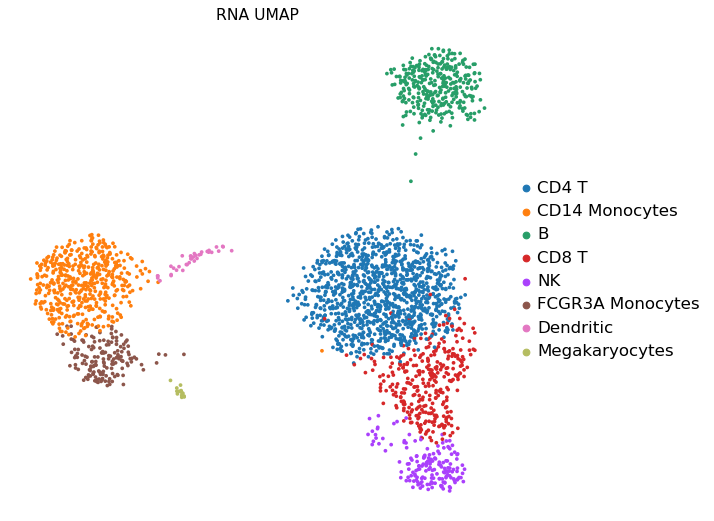

In [5]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(adata, color='cell_type', title='RNA UMAP', 
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

## Clustering cells with TF activity

Here, we first run SCIRA on DoRothEA’s regulons to obtain TFs activity, by using the wrapper function run_scira(). This function can deal with different input types such as pandas dataframe or AnnData objects. The function returns an AnnData object containing the TF activities instead of gene expression.

In [6]:
%%time

# Read Dorothea Regulons for Human
dorothea_hs = dorothea.load_regulons(['A', 'B'])

# Compute SCIRA scores
dorothea.run_scira(adata, dorothea_hs, norm='c', scale=True)

/home/badi/miniconda3/envs/schf/lib/python3.8/site-packages/dorothea/dorothea.py:61: RuntimeWarning: invalid value encountered in true_divide
  r = ssxym / np.sqrt(ssxm * ssym)


CPU times: user 1min 26s, sys: 55.7 s, total: 2min 21s
Wall time: 19.5 s


We then apply Scanpy to cluster the cells following the same protocol than above but using TF activity scores.

In [7]:
sc.pp.neighbors(adata, n_pcs=adata.obsm['dorothea'].shape[1], n_neighbors=10, use_rep='dorothea', key_added='tf')
sc.tl.umap(adata, neighbors_key='tf')

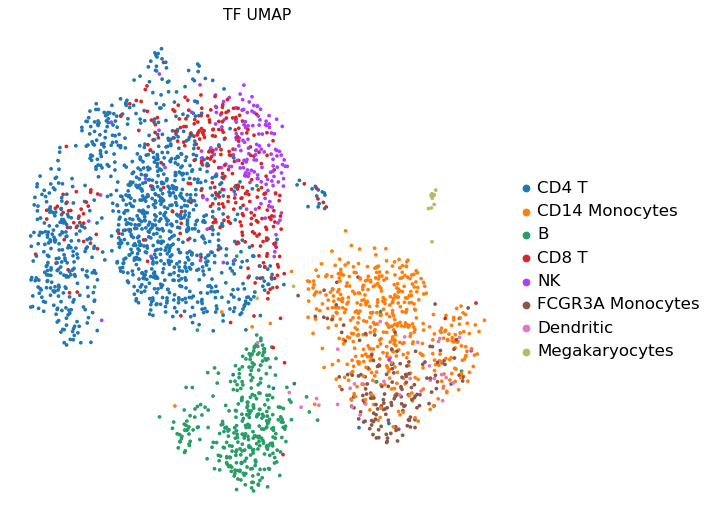

In [8]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(adata, color='cell_type', title='TF UMAP', 
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

## TF activity per cell population

Finally, we characterise the different cell populations based on their TF activities thanks to the previously computed SCIRA scores on DoRothEA’s regulons.

We do it by building linear models for each TF and for each cell population.

In [9]:
tf_adata = AnnData(adata.obsm['dorothea'])
tf_adata.obs['cell_type'] = adata.obs['cell_type']

df = pd.DataFrame((tf_adata.X), index= tf_adata.obs_names, 
                                   columns=tf_adata.var.index)

marker_tfs_dict = dict()

for cell_type in np.unique(tf_adata.obs.cell_type):
    df['cell_type'] = (tf_adata.obs.cell_type == cell_type) * 1
    params_arr = []
    pvalues_arr = []
    
    for tf in tf_adata.var.index:
        mod = smf.ols(formula='{0} ~ {1} - 1'.format(tf, 'cell_type'), data=df)
        res = mod.fit()
        params = res.params.to_list()[0]
        pvalues = res.pvalues.to_list()[0]
        params_arr.append(params)
        pvalues_arr.append(pvalues)
    
    result_df = pd.DataFrame(columns=["change", "p_val", "p_val_adj"])
    result_df['change'] = params_arr
    result_df['p_val'] = pvalues_arr
    result_df['p_val_adj'] = np.array(pvalues_arr) * len(params_arr)
    result_df.index = tf_adata.var.index
    marker_tfs_dict[cell_type] = list(result_df.sort_values('change', ascending=False).index[:3])

         Falling back to preprocessing with `sc.pp.pca` and default params.
/home/badi/miniconda3/envs/schf/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


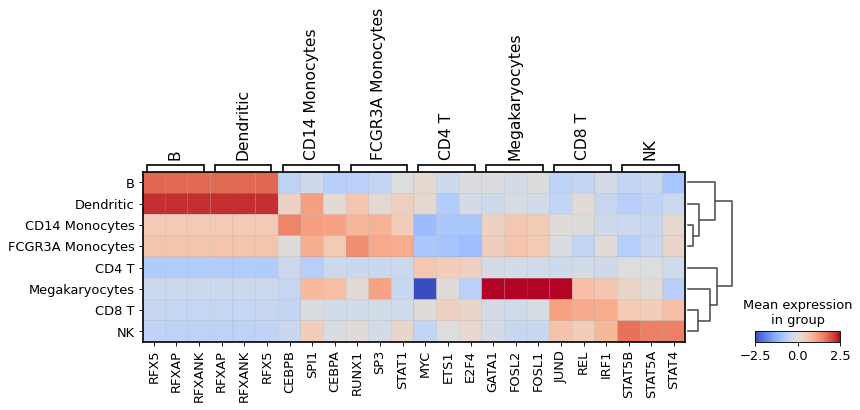

In [10]:
sc.pl.matrixplot(tf_adata, 
                 marker_tfs_dict,
                 groupby='cell_type',
                 cmap='coolwarm',
                 dendrogram=True,
                 vmin=-2.5,
                 vmax=2.5
                )

Once we find the marker TFs for each cell population we can plot them by population:

Or by sample:

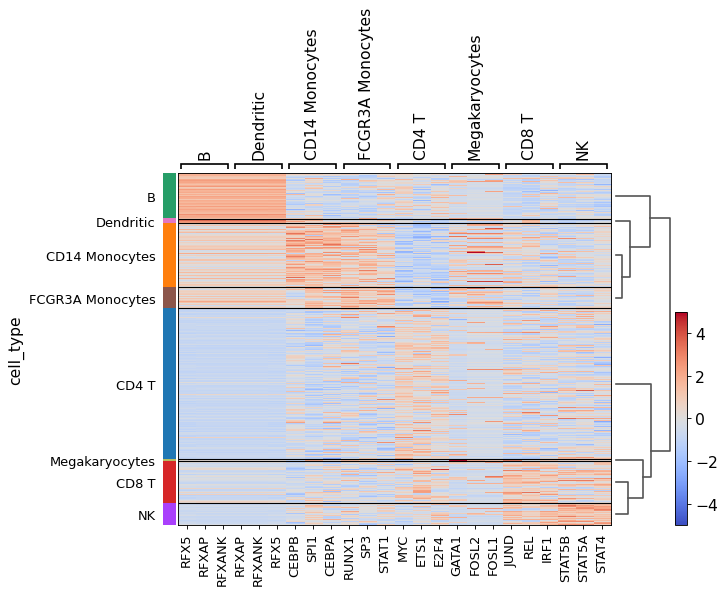

In [11]:
sc.pl.heatmap(tf_adata,
              marker_tfs_dict,
              groupby='cell_type',
              cmap='coolwarm',
              dendrogram=True, 
              vmin=-5,
              vmax=5,
             )